# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

* https://github.com/Luchkata/Algorithmic_Trading_Machine_Learning/blob/main/Algorithmic_Trading_Machine_Learning_Quant_Strategies.ipynb

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list, 
                 start=start_date, 
                 end=end_date).stack()

print('df')
print(df)
print('sp500')
print(sp500)
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['GEV', 'SOLV', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


df
Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2015-09-29 A        31.483562   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361626   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684570   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478710   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.54

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483562   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361626   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684570   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478710   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[989155 rows x 6 columns]

In [2]:
# https://help.yahoo.com/kb/SLN28256.html
# Adj closeは該当するすべての株式分割および配当分配を調整した後の終値です。
# データは、証券価格研究センター (CRSP) の標準に準拠し、適切な株式分割および配当乗数を使用して調整されます。

# https://breakingdownfinance.com/finance-topics/risk-management/garman-klass-volatility/
# https://portfolioslab.com/tools/garman-klass
# Garman Klass は、証券の始値、安値、高値、終値を組み込んだボラティリティ推定式です。
# 欠点はあるものの、Garman-Klass 推定値は、時間間隔の開始時と終了時の価格だけでなく、日中の価格の極値も考慮するため、基本的な式よりも効果的です。
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# RSIとは、「Relative Strength Index」の略で、テクニカルチャートのひとつです。日本語に訳すと「相対力指数」になります。買われすぎか、売られすぎかを判断するための指標として利用されています。
# RSIは、過去一定期間の上げ幅（前日比）の合計を、同じ期間の上げ幅の合計と下げ幅の合計を足した数字で割って、100を掛けたものです。
# いくら値上がり、値下がりしたかはRSIでは判断できません。数値は0～100で表され、一般的に70～80％以上で買われすぎ、20～30％以下で売られすぎと判断されます。
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# ボリンジャーバンドとは、移動平均線とその上下2本ずつの標準偏差からなる線の計5本の線で表わされます。英字表記は「Bollinger bands」となります。
# ボリンジャーバンドは統計学を使って作られていて、大まかにいうと、高い確率で＋2σ(標準偏差)と－2σのラインの間で価格は動くだろうという予測をもとに将来の価格の動きを予測するために使います。
# なお、統計学上、＋2σと－2σの間に収まる確率は95.45%とされています。
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# 「相場の変動率」を解析する指標（計算式）が「ATR（アベレージトゥルーレンジ)」です。 相場の変動が大きい傾向なのか小さい傾向なのかを分析する場合に有効です。 
# 「当日高値-当日安値」「当日高値-前日終値」「当日安値-前日終値」の3つのうち最大の値幅(マド明けを含む最大値幅の計測)を当日の「真の値幅(トゥルーレンジ)」と呼び、
# この「真の値幅」の移動平均線がATR(アベレージトゥルーレンジ)です。
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
             low=stock_data['low'],
             close=stock_data['close'],
             length=14)
    return atr.sub(atr.mean()).div(atr.std())
    
# 今回と関係ないけど日本語でATR出したりと似たようなことしている記事あった　　https://qiita.com/__x__/items/ed91e995aec21ac89c8b
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# MACD（通称マックディー）は、移動平均の発展版で、更に売買シグナルにおいて精度を高くした、トレンド分析の中でも人気のある指標の一つです。
# 「移動平均収束拡散」又は「移動平均収束乖離」などとも呼ばれています。トレンド形成時に威力を発揮するため、逆にボックス相場に弱いのが特徴です。
# 主にMACDとMACDシグナルという2本のラインの交差を売買のタイミングとして用いられることが多く、初心者の方でもシグナルの発見が容易です。
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# １００万株取引されることがわかっているので1e6で割る(?)
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483562   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361626   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684570   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478710   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005572        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000016  26.146757  4.488345   
           YUM       1500600.0          0.000002  36.057165  4.816569   
           ZBH       3610500.0          0.000099  31.893261  4.748085   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623469  5.156108   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.913576  
           AAL          NaN       NaN       NaN       NaN     279.420126  
           AAPL         NaN       NaN       NaN       NaN    7243.973499  
           ABBV         NaN       NaN       NaN       NaN     466.641852  
           ABT          NaN       NaN       NaN       NaN     411.369651  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.570270  4.652196  0.033800 -2.159188     117.651912  
           YUM     4.846536  4.876502  0.142547 -1.363695     184.291052  
           ZBH     4.787752  4.827420 -0.381708 -0.881067     403.591519  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.214922  5.273735  0.651515 -1.188279     256.861393  

[989155 rows x 14 columns]

# Aggregate to monthly level and filter top 150 most liquid stocks for each month.

トレーニング時間を短縮し、機能や戦略を実験するために、毎日の営業データを月末の頻度に変換します。
To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [3]:
# ここから列の並び順が動画と違う？書いてる内容は同じなはずだが・・・
# doller volumeは各銘柄の月全体の平均調整後価格を出したいらしい

# 別にuniqueにしなくても良さそうだけどしてるみたい。
# 全データが日時なため、日時→月次にしたいらしい。
# OHLCとは（Open/High/Low/Close）の省略表記で、ローソク足の価格データセット（始値・高値・安値・終値）である。ここに出来高（Volume）を加え、OHLCVで提供されることも多い。
# OHLCは要らないらしくテクニカル指標を指定したいらしい。インジケーターは列を指定する必要があるのでインジケータ
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

# 時系列データを元データより高い頻度または低い頻度で再度サンプリングすることをリサンプリングと呼ぶ。MはMonthly
# 今は日時がスタックしているdfをticker単位でunstackして、dollar_volumeとテクニカル指標をそれぞれ月次にresampleして、dollar_volumeは平均を出しつつ、
# テクニカル指標はlastで月末の値をシンプルに指定しつつstackし直す
# dropnaは欠損値を落とす
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.992831   39.023186         -0.001992  73.421400   
           AAL        287.915804   39.429924         -0.000966  40.718899   
           AAPL      4029.441659   26.890560         -0.003209  55.537311   
           ABBV       337.563947   40.393543         -0.059549  49.376920   
           ABT        211.659061   38.293560         -0.011216  56.962478   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.983159   78.671936         -0.000020  33.116246   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.971017  108.026909          0.000171  55.245465   
           GEHC       212.275849   66.130219          0.000185  40.922342   
           KVUE       677.910277   20.218124          0.000032  35.706337   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.545992  3.618440  3.690888 -1.033887  0.567158  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418773  
           AAPL    3.282983  3.326297  3.369611 -0.967900 -0.142790  
           ABBV    3.726695  3.774943  3.823191 -0.526809  0.145678  
           ABT     3.656056  3.677909  3.699763 -1.064842  0.335556  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.374104  4.419394  4.464683 -1.028320 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.653660  4.693834  4.734007 -0.436215  0.366876  
           GEHC    4.155436  4.212972  4.270508 -0.893478 -1.116463  
           KVUE    3.024299  3.099281  3.174263 -0.899746 -1.435621  

[46704 rows x 9 columns]

In [4]:
# Calculate 5-year rolling average of dollar volume for each stocks before filtering.
# それを下に各月のもっとも流動性の高い１５０種類をピックアップしたいらしい

# ローリング平均では、データ・セットの平均が継続的に更新され、その時点までのデータすべてが算入されます。
# 例えば、2012 年 3 月の返品数量のローリング平均は、1 月、2 月、3 月の返品数量を加算し、その合計を 3 で除算して計算されます。
# locは行名もしくは列名を指定することで特定の値を抽出できます。（行名や列名をラベルと置き換えて頂いても問題ありません。）
# ilocはindexを指定することで特定の値を抽出できます。つまり、行、列を番号（数字が０のインデックス）で指定します。

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134335         -0.000176  62.203558  3.604673   
           AAPL     26.248028         -0.002384  49.891086  3.295542   
           ABBV     40.245117         -0.046691  27.477752  3.753446   
           ABT      34.293457         -0.007492  38.008880  3.554632   
           ACN     103.569618         -0.004643  53.823661  4.637342   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.783058         -0.000011  54.722520  3.988367   
           XOM     114.292953          0.000026  59.440179  4.695106   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655493  3.706314  0.402199  1.131596  
           AAPL    3.324423  3.353305 -1.038688 -0.195978  
           ABBV    3.807610  3.861774 -0.893132 -0.760593  
           ABT     3.605106  3.655580 -1.035224 -0.650888  
           ACN     4.648980  4.660617 -0.996806 -0.135456  
...                     ...       ...       ...       ...  
2023-09-30 WMT     4.005838  4.023309 -0.196381  0.399458  
           XOM     4.735205  4.775304  0.601335  1.400623  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

# 4.calculate monthly returns for different time horizons as features
To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.
例えば、モメンタムパターンを反映する時系列ダイナミクスを捉えるために、ラグで特定される様々な月次期間のリターンを計算する、 
.pct_change(lag)という方法で過去のリターンを計算する、すなわち、様々な月次期間のリターンをラグで識別する。
↑訳してもわからん

時間軸で分けたいろいろなデータを取ることで該当銘柄のモメンタムを見れるらしい

In [5]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        # diff()がA - Bで差分を算出するのに対し、pct_change()は(A - B) / Bで変化率を算出する。
        # 3^4 = 3 ** 4 = pow(3,4) その結果は冪 (べき、英: power) と呼ばれる。表現の揺れにより同じ概念は日本語で「累乗」とも表現されている
        # 四分位数とは、データを大きさの順に並べて、個数を４等分できる値のことです。森からうさぎを40羽連れてきて、体の大きさ順に並べます。
        # うさぎをピッタリ４等分できる線は、10と11番目の間、20と21番目の間、30と31番目の間の線になります。これが四分位数です。
        # pipe.clip 外れ値を四分位範囲を用いてクリップする https://ensekitt.hatenablog.com/entry/2018/02/13/200000
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534168         -0.000363  41.051769  3.849110   
           AAPL     39.767761         -0.000998  69.196747  3.596048   
           ABBV     67.491150         -0.034008  55.247871  4.196702   
           ABT      48.493382         -0.005190  53.844921  3.892568   
           ACN     129.399750         -0.003925  69.365441  4.802675   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.783058         -0.000011  54.722520  3.988367   
           XOM     114.292953          0.000026  59.440179  4.695106   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.642922  3.689796 -0.906642 -0.039275   0.096807   
           ABBV    4.243063  4.289423  0.375557  0.473815   0.022728   
           ABT     3.916137  3.939707 -1.040044  0.276134   0.021276   
           ACN     4.842354  4.882034 -0.986514  0.352343   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 WMT     4.005838  4.023309 -0.196381  0.399458  -0.000676   
           XOM     4.735205  4.775304  0.601335  1.400623   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10340 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas
Fama-French 5ファクターモデルとは、Fama-French 3ファクターモデルに、収益性（Profitability）と投資（Investment）のファクターを追加したモデルであり、下記式であらわされるモデルである。
We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.
本論文では、線形回帰を用いて一般的なリスク要因に対する資産のエクスポージャーを推定するためのFama-Frenchデータを紹介する。
市場リスク、規模、バリュー、営業収益性、投資の5つのFama-Frenchファクターは、経験的に資産リターンを説明することが示されており、ポートフォリオのリスク／リターン・プロファイルを評価するために一般的に使用されている。したがって、過去のファクター・エクスポージャーを財務的特徴としてモデルに含めることは自然なことです。
pandas-datareader を使って過去のファクターリターンにアクセスし、RollingOLS のローリング線形回帰を使って過去のエクスポージャを推定することができます。

SMB (Small Minus Big) is the average return on the nine small stock portfolios minus the average return on the nine big stock portfolios,

HML (High Minus Low) is the average return on the two value portfolios minus the average return on the two growth portfolios,

RMW (Robust Minus Weak) is the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios,

CMA (Conservative Minus Aggressive) is the average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios,

Rm-Rf, the excess return on the market, value-weight return of all CRSP firms incorporated in the US and listed on the NYSE, AMEX, or NASDAQ that have a CRSP share code of 10 or 11 at the beginning of month t, good shares and price data at the beginning of t, and good return data for t minus the one-month Treasury bill rate (from Ibbotson Associates).

SMB（Small Minus Big）は、9つの小型株ポートフォリオの平均リターンから 9 つの大型株ポートフォリオの平均リターンを差し引いたものです、
HML（High Minus Low）は、2つのバリュー・ポートフォリオの平均リターンから2つのグロース・ポートフォリオの平均リターンを差し引いたものです、
RMW（Robust Minus Weak）は、2つの強固な営業収益性ポートフォリオの平均リターンから2つの脆弱な営業収益性ポートフォリオの平均リターンを差し引いたものです、
CMA（Conservative Minus Aggressive）は、2つの保守的投資ポートフォリオの平均リターンから2つの積極的投資ポートフォリオの平均リターンを引いたものである、
Rm-Rfは、米国で設立され、NYSE、AMEX、またはNASDAQに上場しているすべてのCRSP企業のうち、t月初にCRSPの株式コードが10または11であり、t月初に良好な株式と価格のデータ、およびtの良好なリターンのデータから1ヶ月物国庫短期証券レートを差し引いた市場、バリューウェイトリターンの超過リターン（Ibbotson Associatesより）。

In [6]:
# Kenneth French's data library：ケネス・R・フレンチのHPがpandas_datareaderに対応しているっぽい
# https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010'
              )[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10340 rows x 6 columns]

In [7]:
# 属性sizeで全要素数、属性shapeで形状（行数、列数）が取得できる。要素数が少ない銘柄を除外しているっぽい
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
# ここで「key1 が A の行だけフィルタリングしたい」という場合、どうすればいいか。→pandas.MultiIndex.get_level_values というメソッドを使うと、Multi-Index の値にアクセスできる。
# isin()メソッドは、リスト内の値が別のリストに含まれているかどうかをチェックするために利用します。リストの値をカンマで区切って指定し、リストの値が含まれている場合はTrue、含まれていない場合はFalseを返します。
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10309 rows x 6 columns]

In [8]:
# 最小二乗法 (OLS) は、最もよく知られている回帰分析手法です。これは、すべての空間回帰分析の開始点でもあります。
# 理解または予測しようとしている変数またはプロセスのグローバル モデルを作成し、そのプロセスを表す単一の回帰方程式を作成します。
# Rolling OLS applies OLS across a fixed windows of observations and then rolls (moves or slides) the window across the data set. 
# They key parameter is window which determines the number of observations used in each OLS regression. 
# By default, RollingOLS drops missing values in the window and so will estimate the model using the available data points.
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332655 -0.165644  0.267343  0.310366  0.106902
           WFC     1.121746  0.300521  2.061532 -0.439491 -1.517556
           WMT     0.700556 -0.315600 -0.413434 -0.142906  0.508472
           XOM     0.983511 -1.093759  1.756776 -0.640867 -0.368454

[10309 rows x 5 columns]

In [9]:
# 計算したbetasをもともとのdataに混ぜたいが、rolling factorは次の月末の結果を計算しておりそのままだと１ヶ月のズレが生じてしまうため、betasを一ヶ月早めてから(shift())混ぜる
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
# shift()デフォルトでは下方向に1行ずれる。行数はそのままなので、最後の行のデータは削除される。
data = (data.join(betas.groupby('ticker').shift()))

# 欠損値は平均値で埋める
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10065 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10065 non-null  float64
 1   rsi               10065 non-null  float64
 2   bb_low            10065 non-null  float64
 3   bb_mid            10065 non-null  float64
 4   bb_high           10065 non-null  float64
 5   atr               10065 non-null  float64
 6   macd              10065 non-null  float64
 7   return_1m         10065 non-null  float64
 8   return_2m         10065 non-null  float64
 9   return_3m         10065 non-null  float64
 10  return_6m         10065 non-null  float64
 11  return_9m         10065 non-null  float64
 12  return_12m        10065 non-null  float64
 13  Mkt-RF            10065 non-null  float64
 14  SMB               10065 non-null  float64
 15  HML       

# 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features

In [10]:
# hypothesis: rsi 70 stock has stock momentum
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html 
# If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.
# centroid 【名】 《物理》質量中心
target_rsi_values = [30, 45, 55, 70]

initial_centeroids = np.zeros((len(target_rsi_values), 18))

# 6=rsi
initial_centeroids[:,6] = target_rsi_values

initial_centeroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [11]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centeroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051769  3.849110  3.921750  3.994389   
           AAPL           -0.000998  69.196747  3.596048  3.642922  3.689796   
           ABBV           -0.034008  55.247871  4.196702  4.243063  4.289423   
           ABT            -0.005190  53.844921  3.892568  3.916137  3.939707   
           ACN            -0.003925  69.365441  4.802675  4.842354  4.882034   
...                             ...        ...       ...       ...       ...   
2023-09-30 WFC             0.000016  40.920278  3.702645  3.743015  3.783384   
           WMT            -0.000011  54.722520  3.988367  4.005838  4.023309   
           XOM             0.000026  59.440179  4.695106  4.735205  4.775304   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039275   0.096807   0.015249   0.044955   
           ABBV    0.375557  0.473815   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276134   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352343   0.064180   0.048455   0.037203   
...                     ...       ...        ...        ...        ...   
2023-09-30 WFC    -0.558742 -0.282325  -0.015500  -0.057917  -0.013554   
           WMT    -0.196381  0.399458  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275749 -0.271694   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199021   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166702   
...                      ...        ...         ...       ...       ...   
2023-09-30 WFC      0.016712   0.000702    0.003255  1.137640  0.314482   
           WMT      0.017574   0.016553    0.020256  0.740055 -0.261890   
           XOM      0.012838   0.008747    0.027037  1.005968 -1.051370   
           MRNA    -0.071952  -0.064976   -0.015431  1.155154  0.762525   
           UBER     0.057244   0.066838    0.043691  1.078922  1.162540   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563294        0  
           AAPL   -0.591145  0.647782  0.458079        2  
           ABBV   -0.033102  0.241982  0.164920        3  
           ABT    -0.529384  0.252408  0.970211        3  
           ACN    -0.328213  0.267788  0.168884        2  
...                     ...       ...       ...      ...  
2023-09-30 WFC     2.009073 -0.404339 -1.468838        3  
           WMT    -0.522678 -0.126426  0.642628        1  
           XOM     1.707833 -0.675680 -0.284025        1  
           MRNA   -1.165677  0.590306  0.993548        3  
           UBER   -0.257003 -1.482231 -0.450323        2  

[10065 rows x 19 columns]

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    # scatter first column=atr, second column=rsi
    # 動画と自分の表の列の並び順が違うので書き換えちゃう
    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    # plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    # plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    # plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    # plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

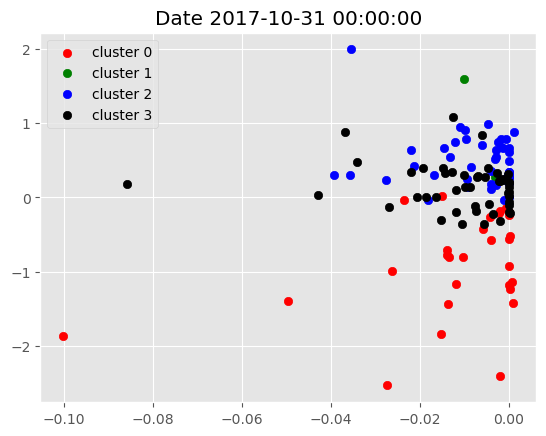

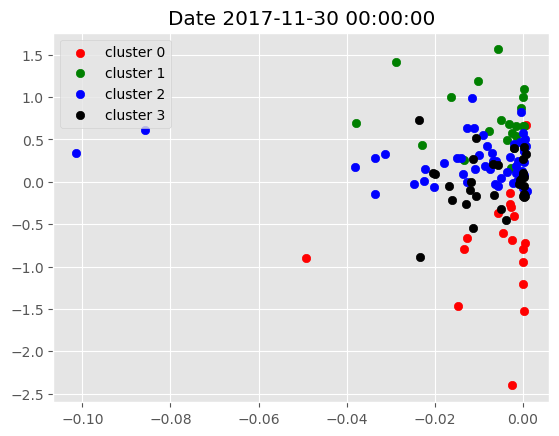

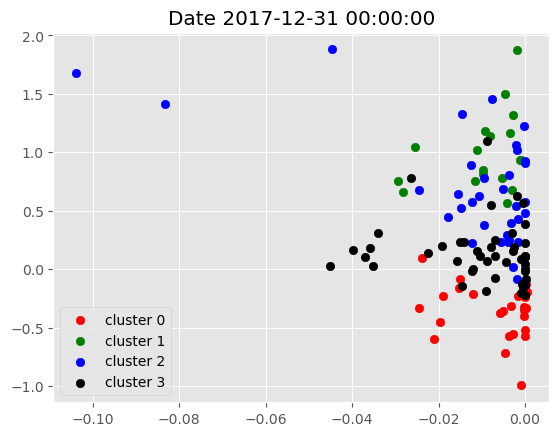

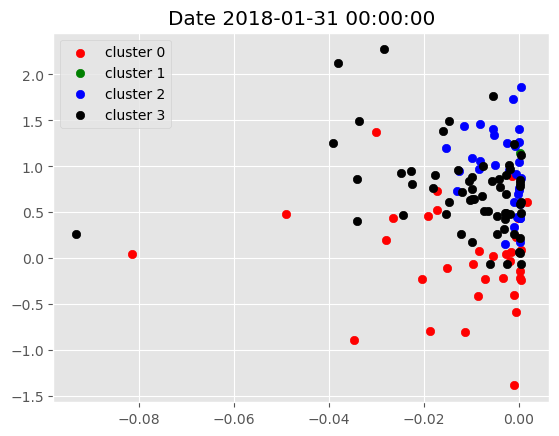

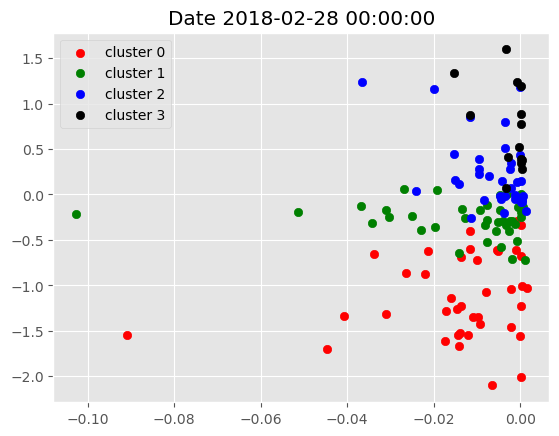

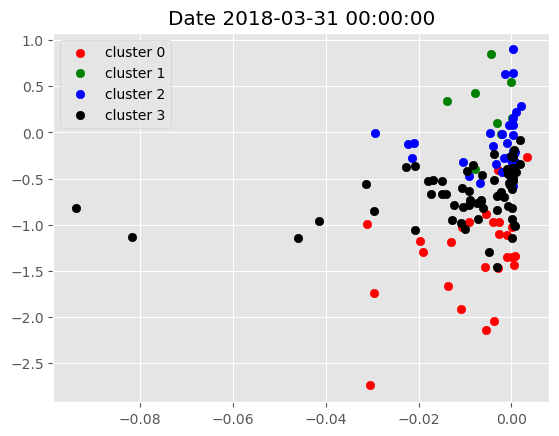

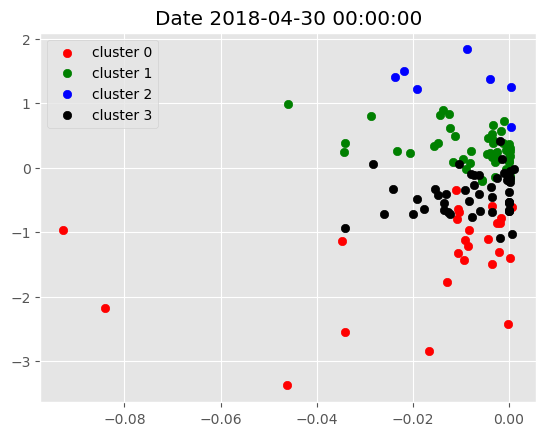

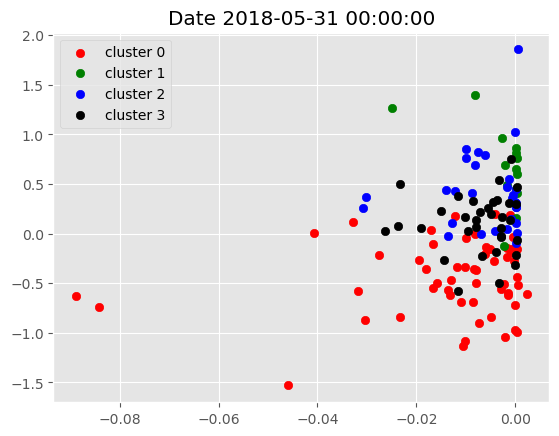

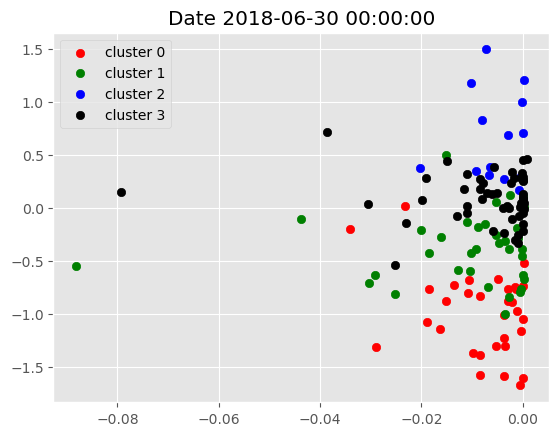

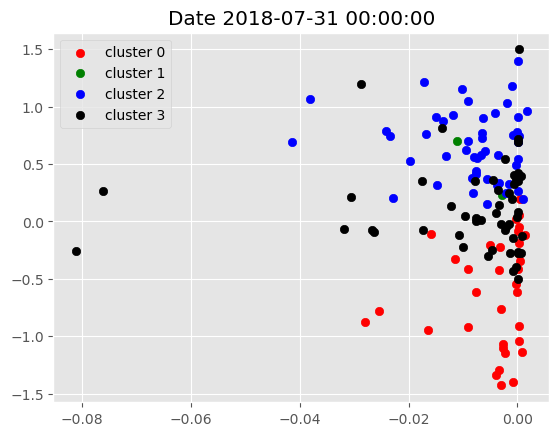

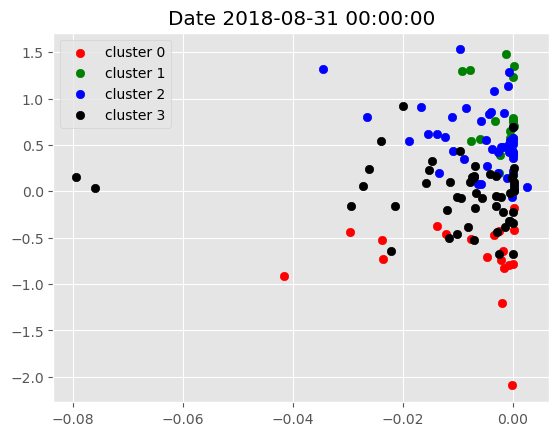

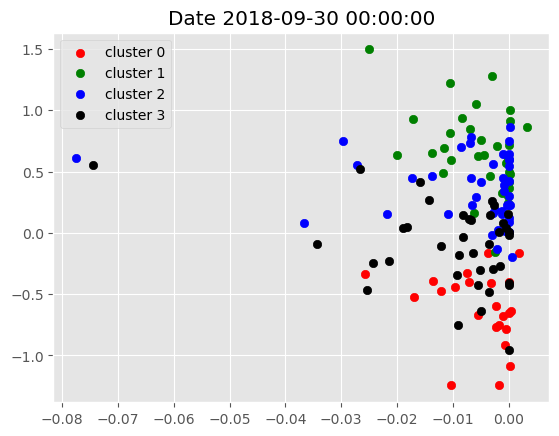

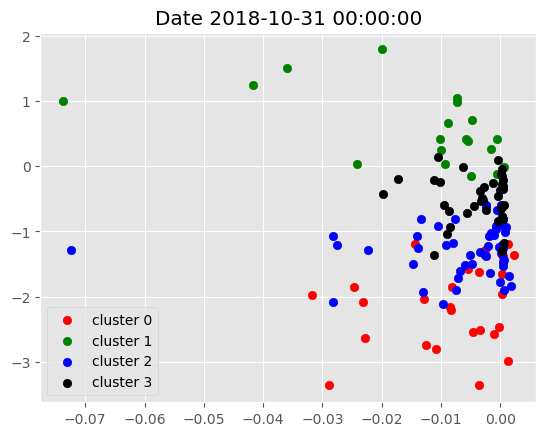

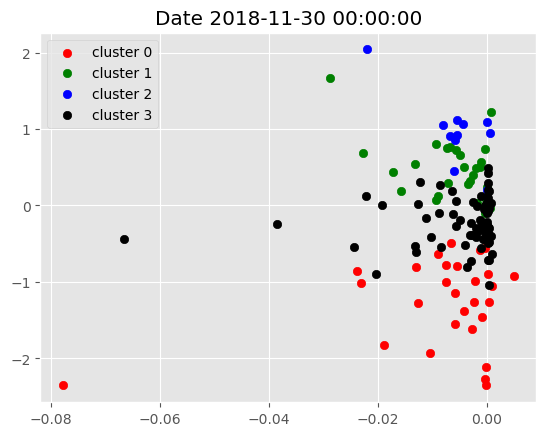

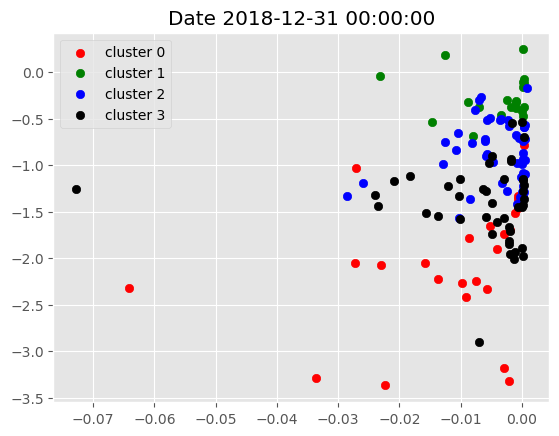

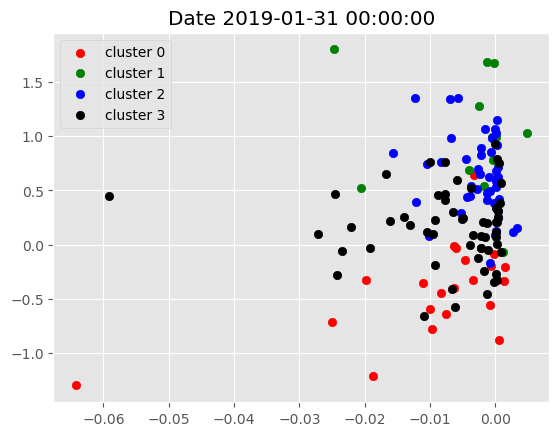

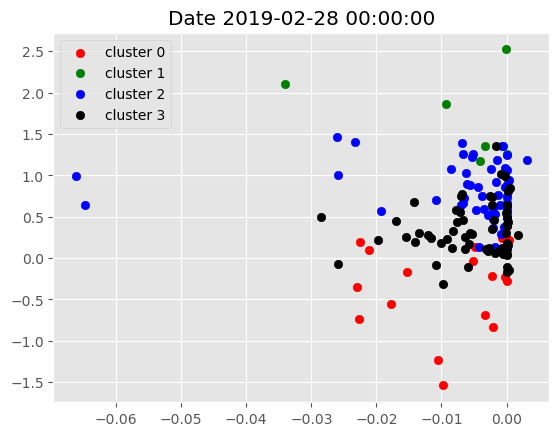

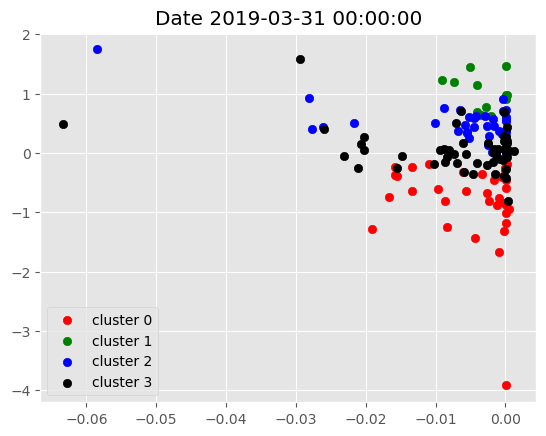

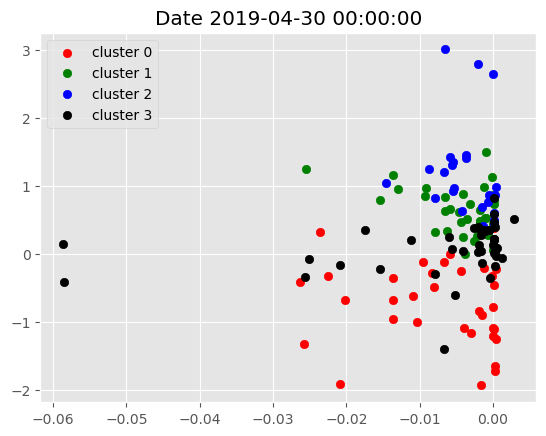

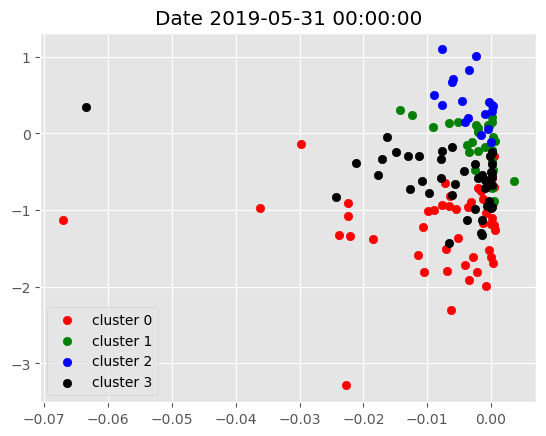

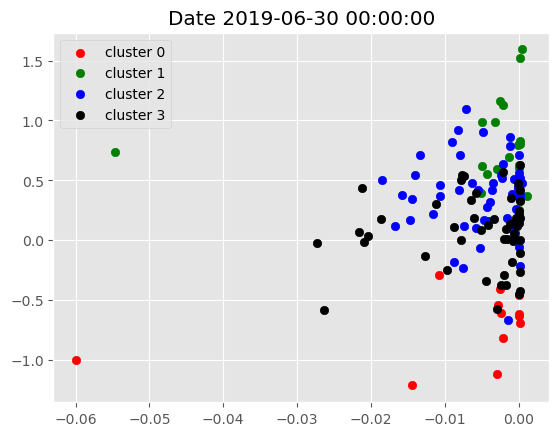

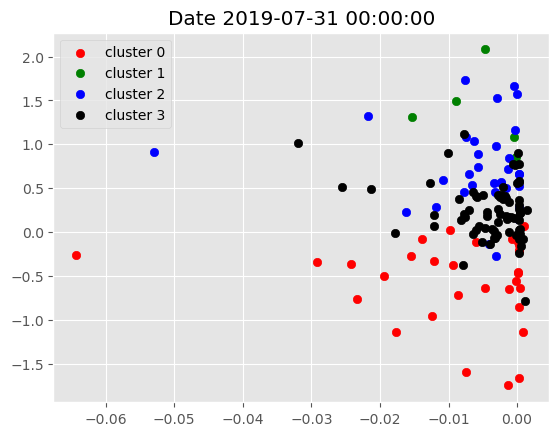

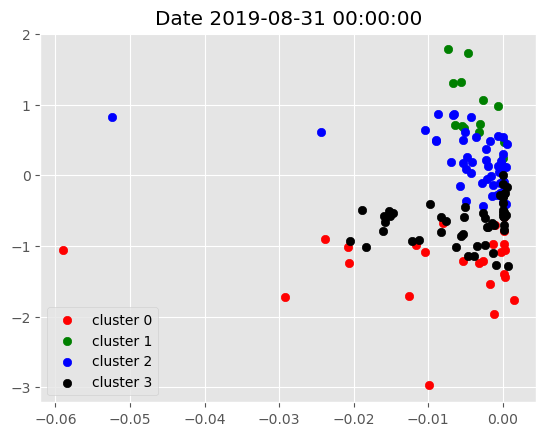

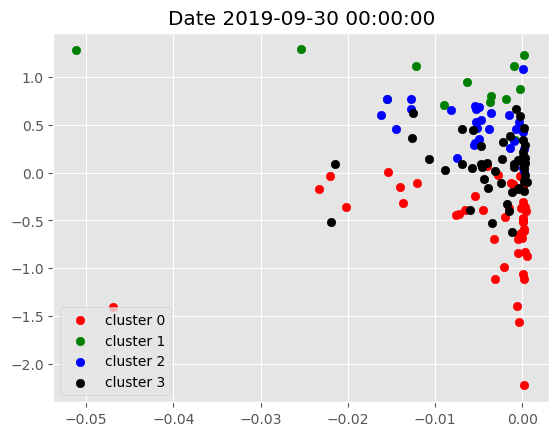

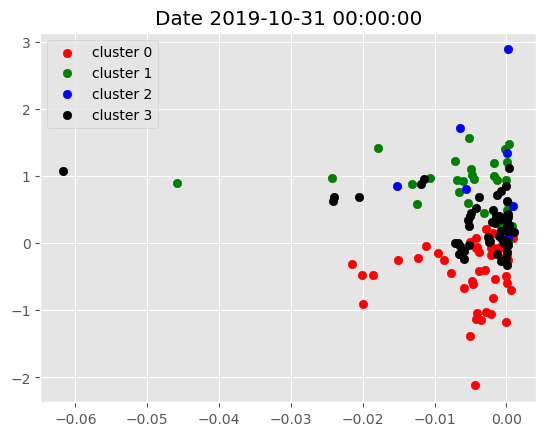

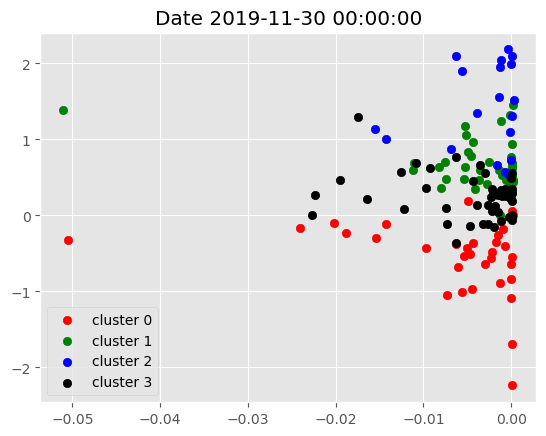

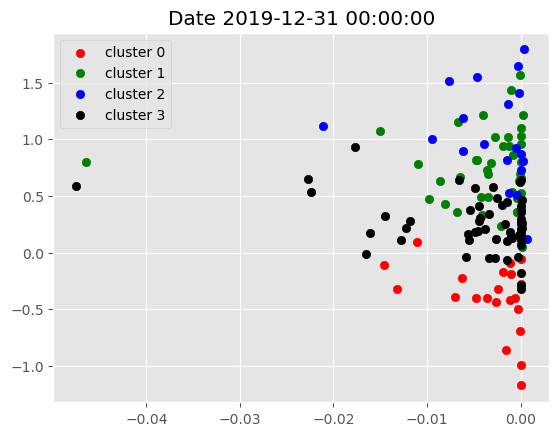

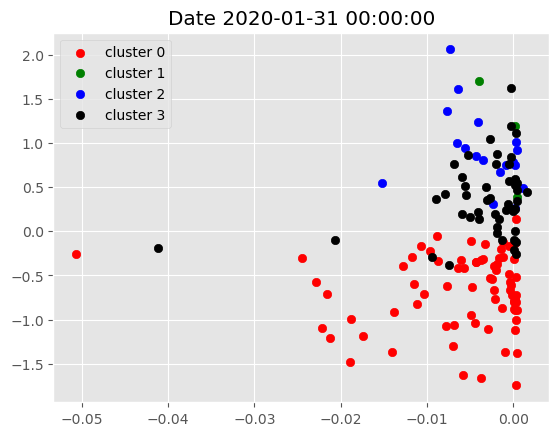

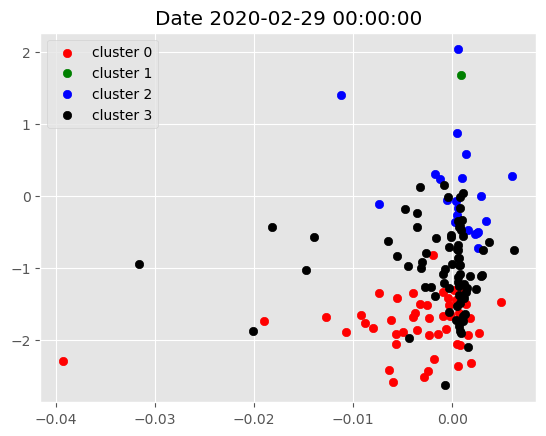

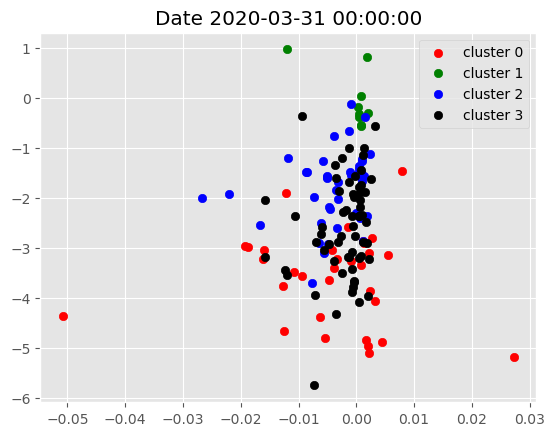

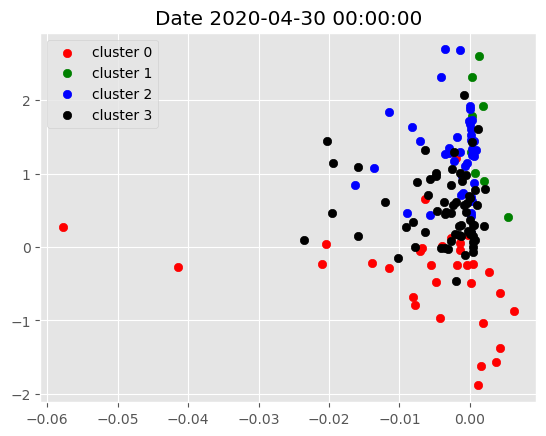

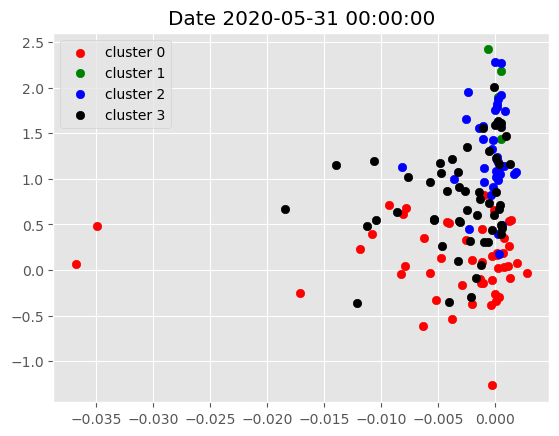

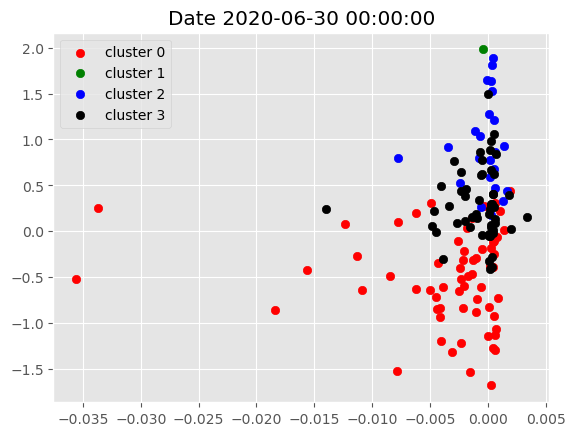

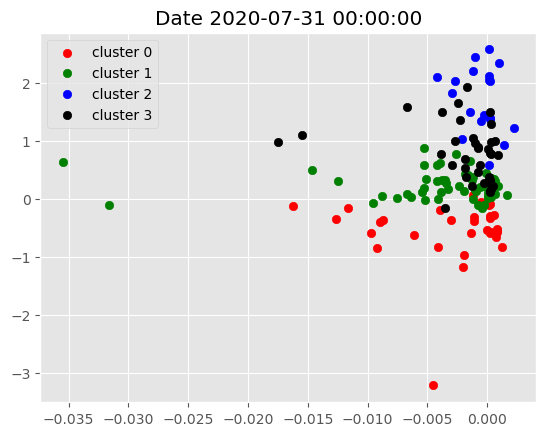

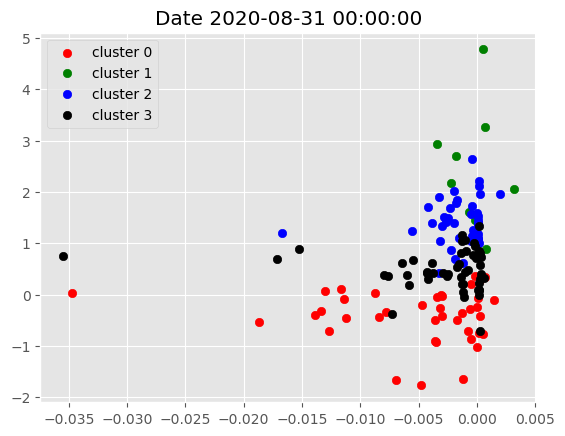

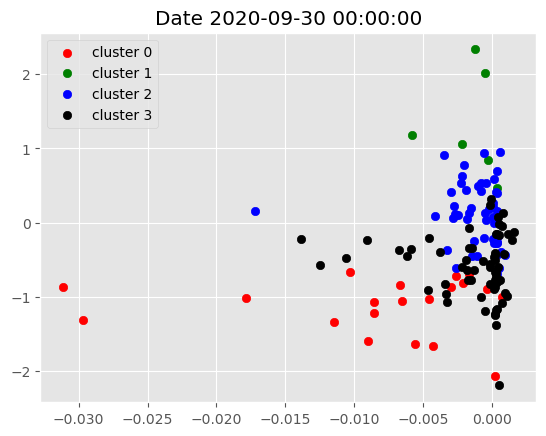

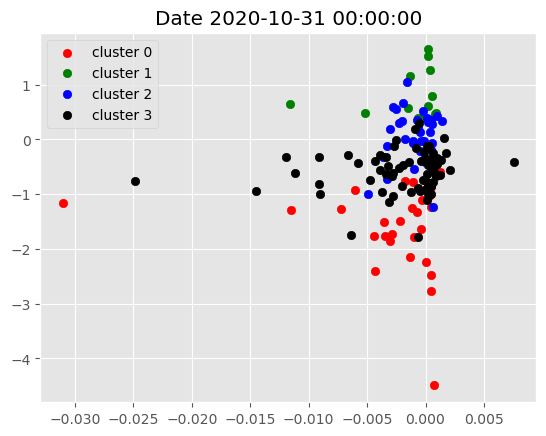

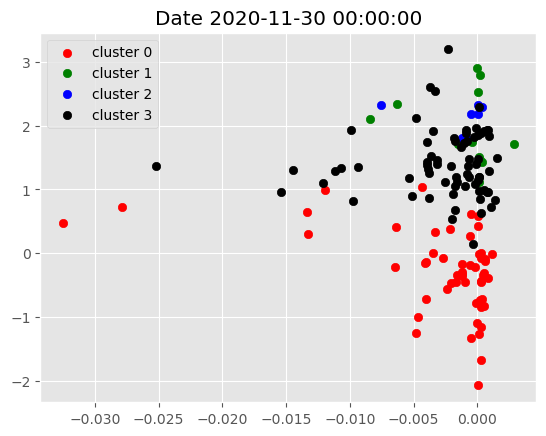

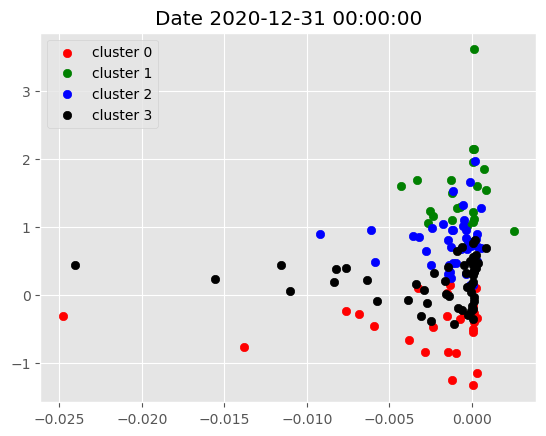

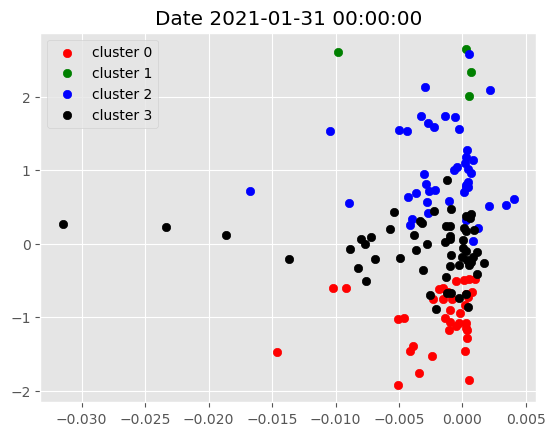

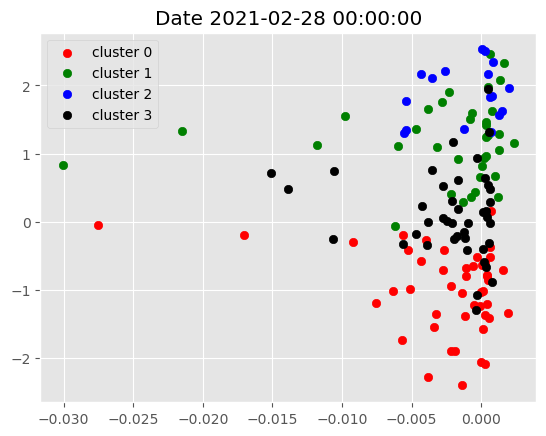

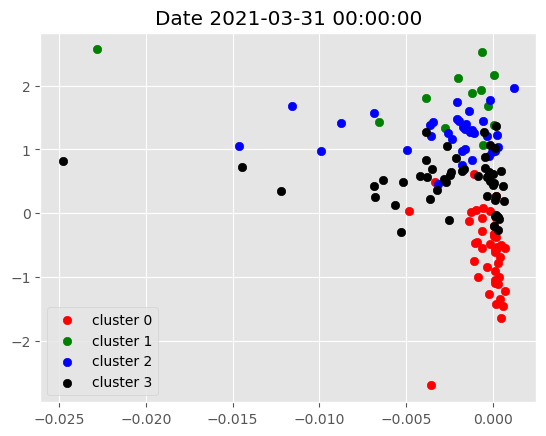

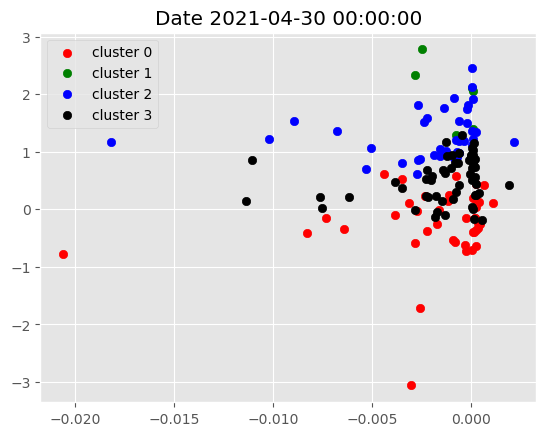

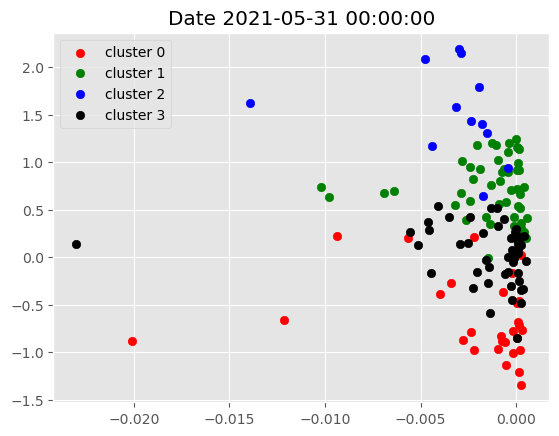

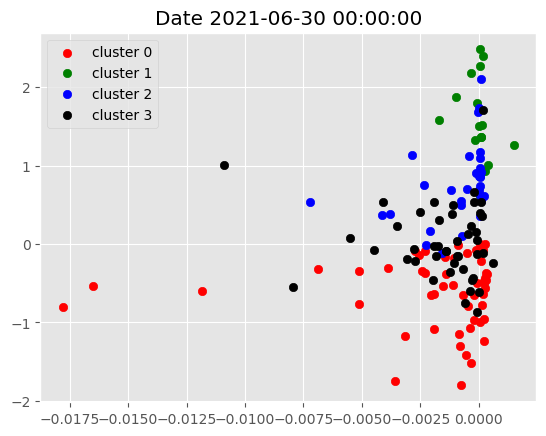

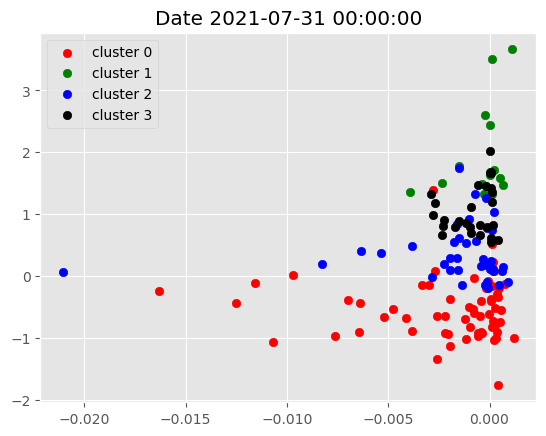

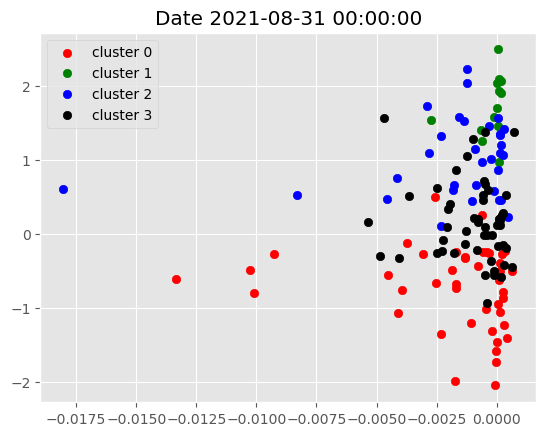

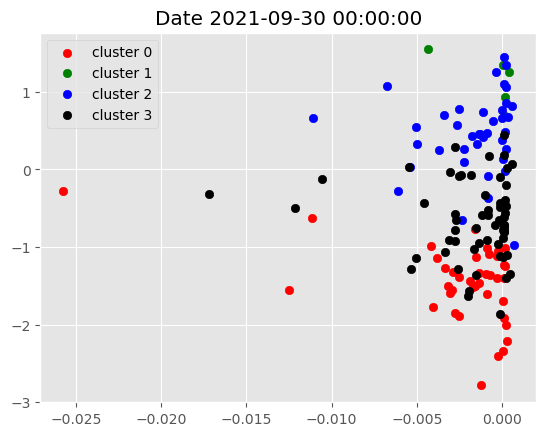

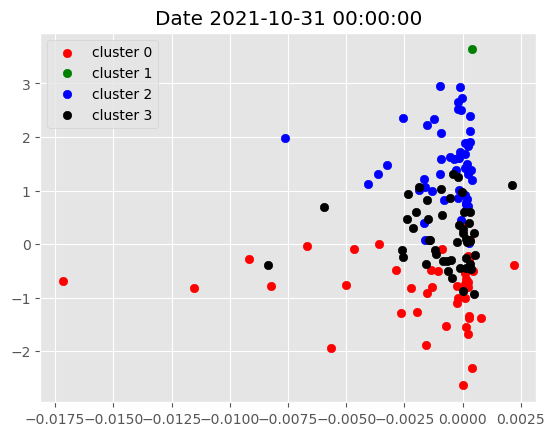

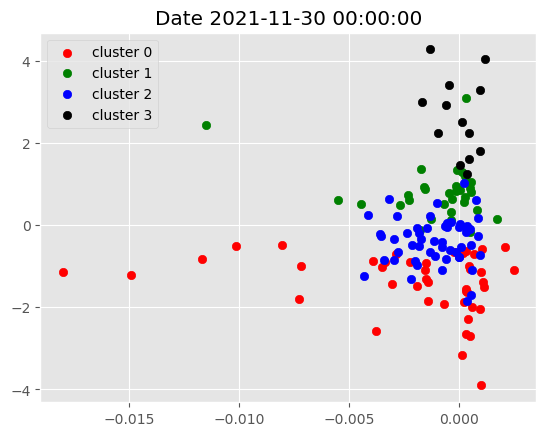

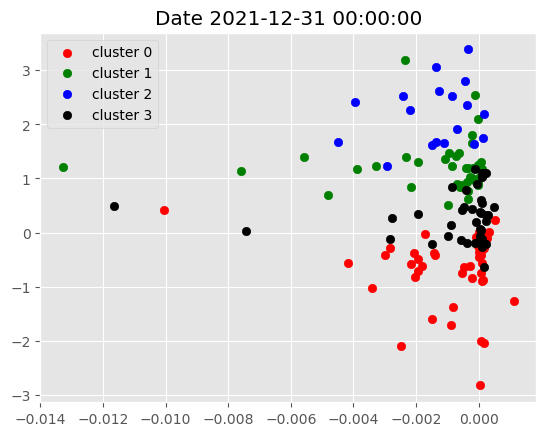

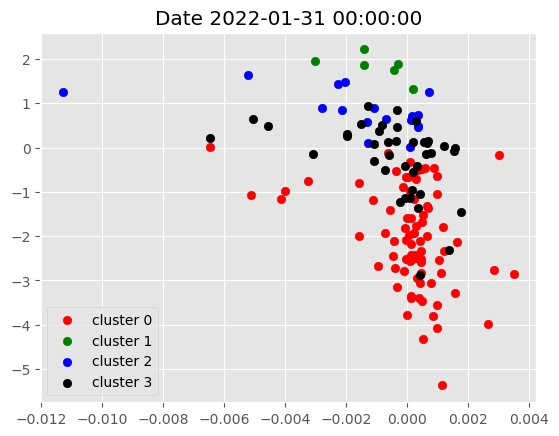

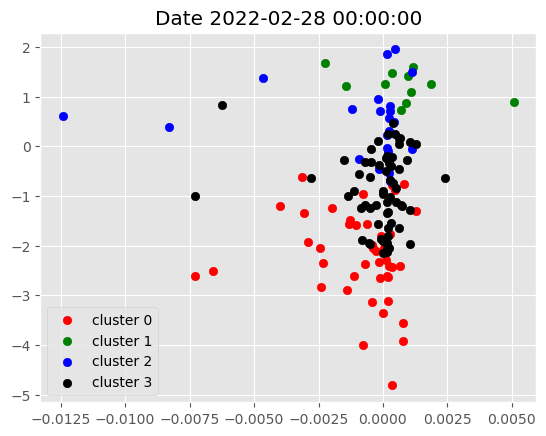

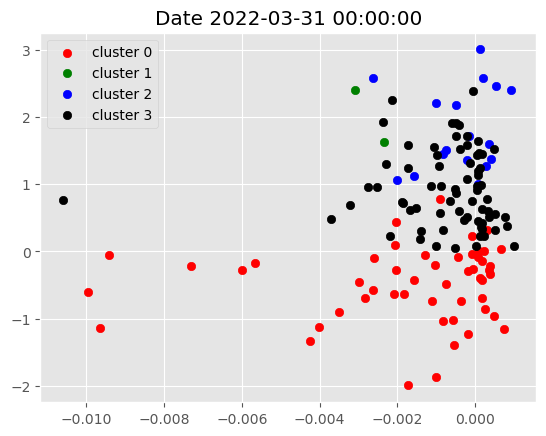

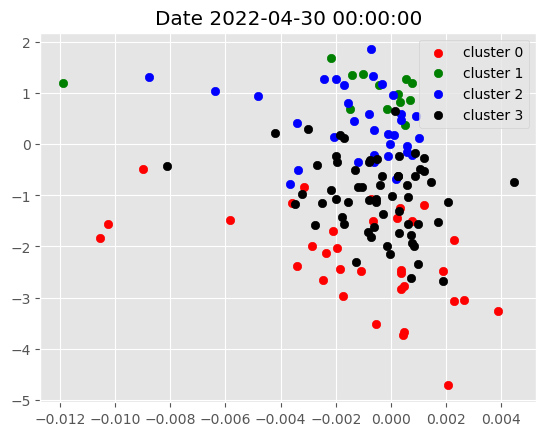

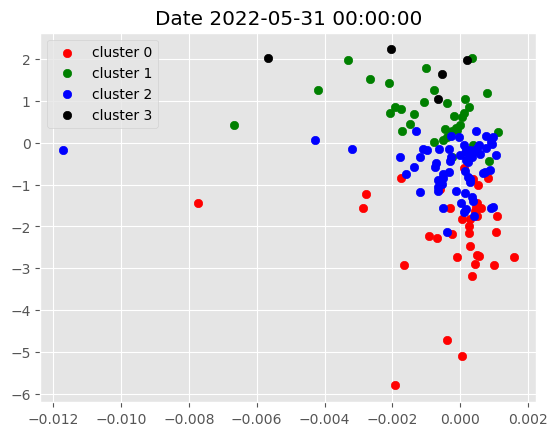

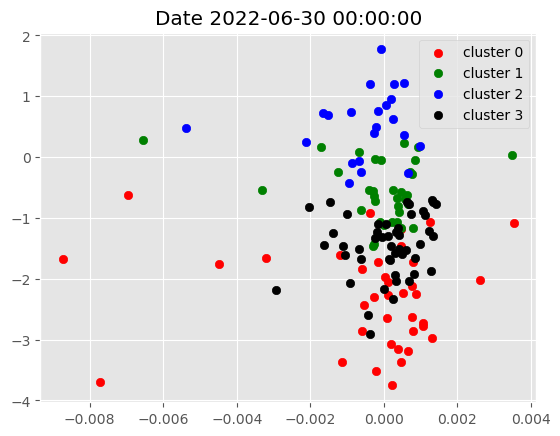

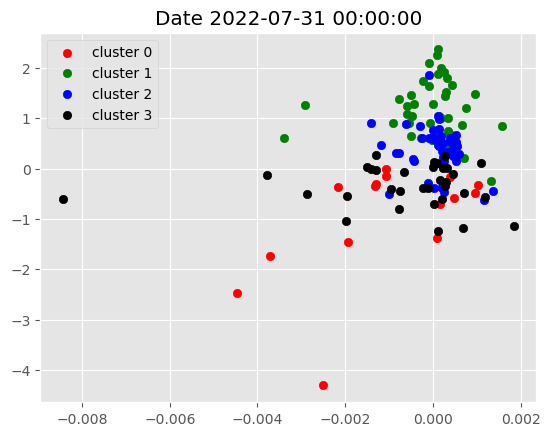

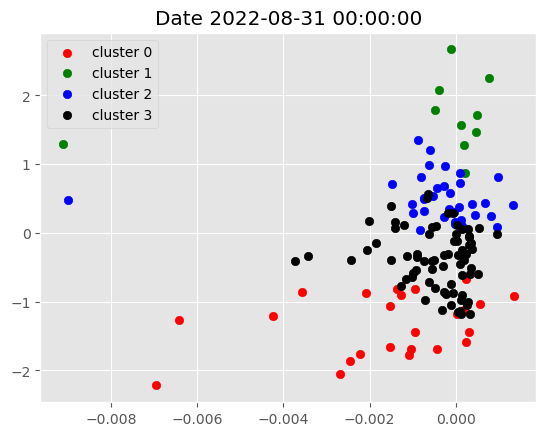

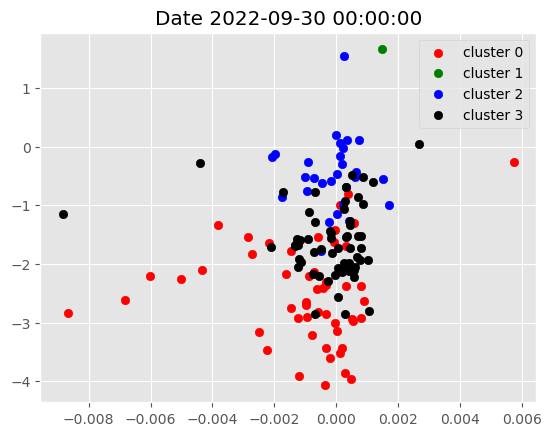

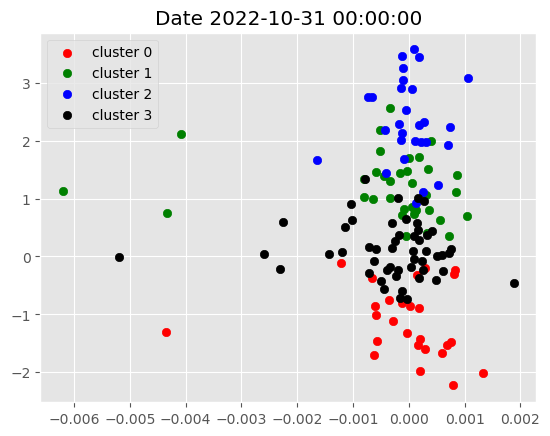

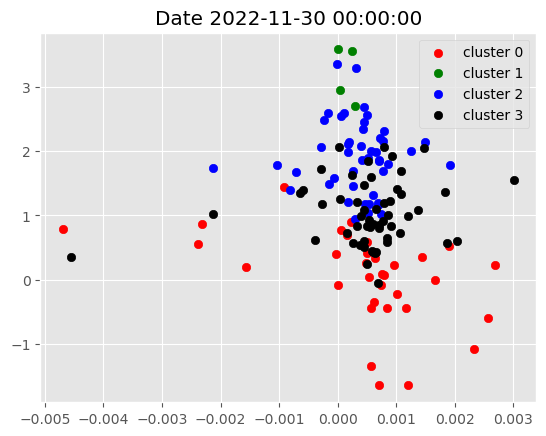

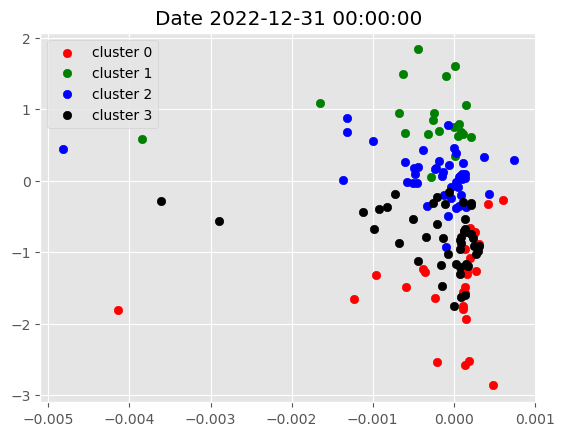

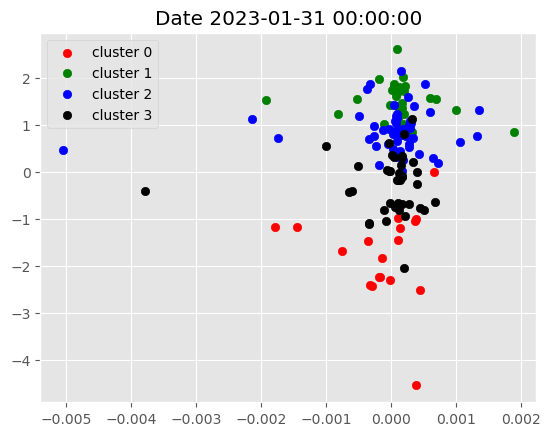

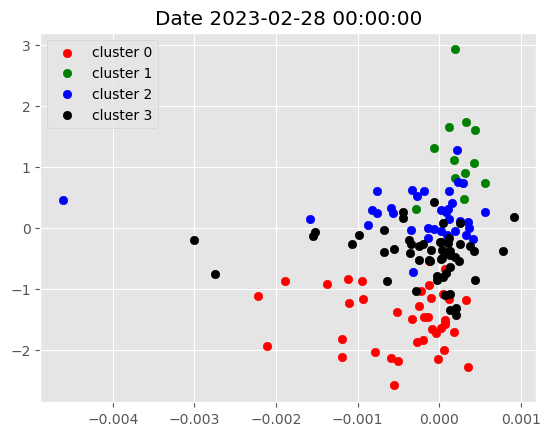

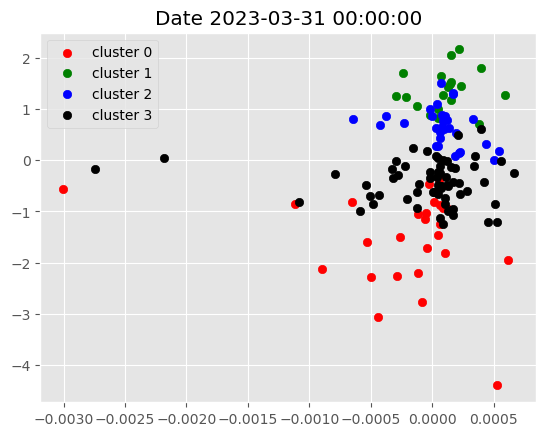

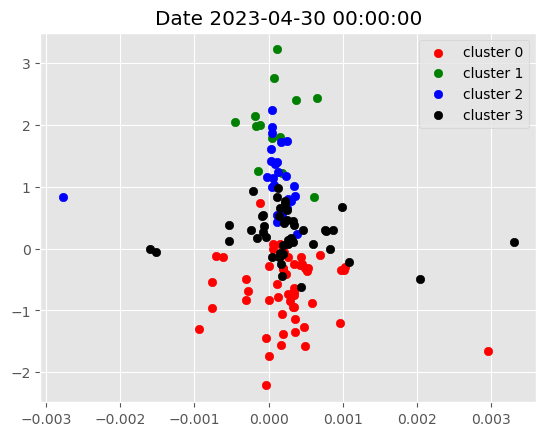

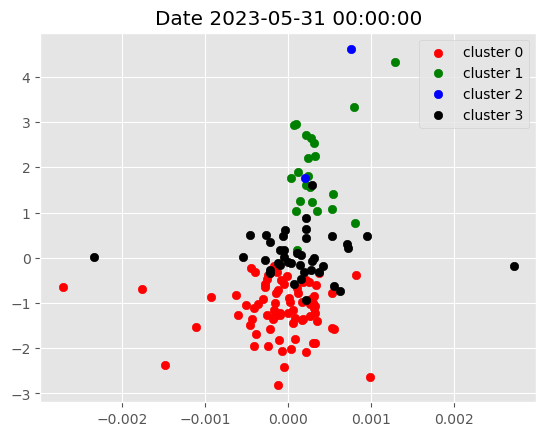

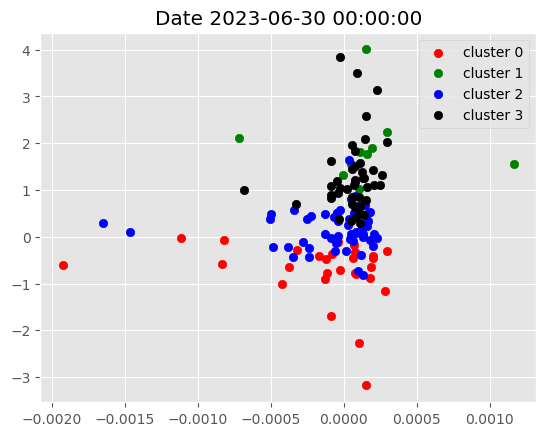

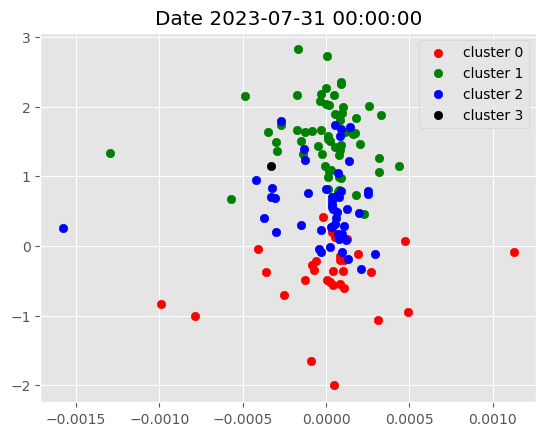

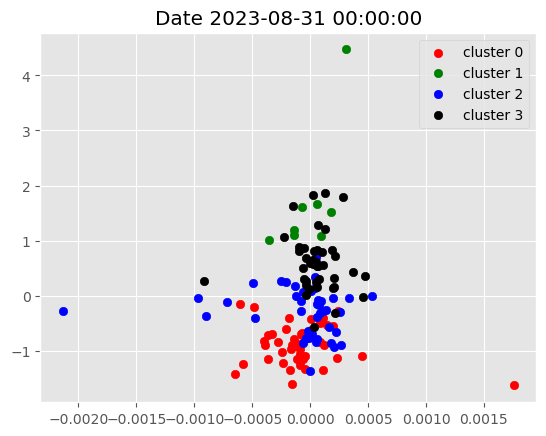

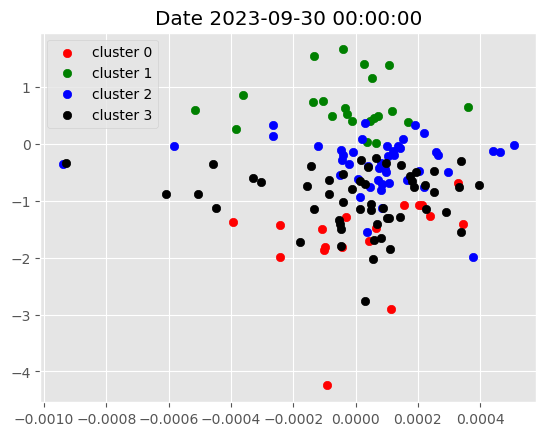

In [13]:
# 動画と指標の数値がぜんぜん違うので、多分カラム順番が間違っている
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i,level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)
    

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [14]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

# 日付が月の最終日になっているので+1日して月初に変えたい
filtered_df.index = filtered_df.index+pd.DateOffset(1)

# 日付と重みをもたせる
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

# 月ごとに投資するべき銘柄のリストを出力できる
fixed_dates

{'2017-11-01': ['ABBV',
  'ABT',
  'AZO',
  'BA',
  'BKNG',
  'BMY',
  'BRK-B',
  'C',
  'COST',
  'CSCO',
  'CVX',
  'DAL',
  'DG',
  'EA',
  'EBAY',
  'FDX',
  'GM',
  'GS',
  'HAL',
  'HON',
  'IBM',
  'ILMN',
  'JNJ',
  'KO',
  'KR',
  'LMT',
  'LOW',
  'MDLZ',
  'MDT',
  'MO',
  'MS',
  'NFLX',
  'NKE',
  'ORLY',
  'OXY',
  'PANW',
  'PXD',
  'RTX',
  'SBUX',
  'SCHW',
  'TGT',
  'TMO',
  'UNP',
  'UPS',
  'USB',
  'VZ',
  'WDC',
  'WYNN'],
 '2017-12-01': ['AAPL',
  'AMGN',
  'BIIB',
  'BMY',
  'CMCSA',
  'CMG',
  'COP',
  'CRM',
  'DD',
  'EOG',
  'GILD',
  'GM',
  'GOOG',
  'GOOGL',
  'JNJ',
  'KO',
  'LLY',
  'MA',
  'MCK',
  'MDT',
  'META',
  'NVDA',
  'ORCL',
  'PANW',
  'PG',
  'PXD',
  'PYPL',
  'STZ',
  'TGT',
  'TMO',
  'TXN',
  'ULTA',
  'V',
  'WBA'],
 '2018-01-01': ['ABBV',
  'ADBE',
  'AMZN',
  'C',
  'CHTR',
  'CMCSA',
  'CSX',
  'CVS',
  'DD',
  'DHR',
  'DIS',
  'EBAY',
  'ELV',
  'F',
  'GOOG',
  'GOOGL',
  'GS',
  'HON',
  'HUM',
  'IBM',
  'ILMN',
  'JNJ',
  'K

## Define portfolio optimization function
We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [15]:
# それぞれの銘柄にどれくらいの割合で投資すべきか重み付けをしたい
# 効率的フロンティア　（Efficient Frontier）とは、分散投資を実施したときに実現するポートフォリオの中で、あるリスクの水準で最大のリターンを獲得できるポートフォリオの集合のことを指す。

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    # sample_covは標本分散共分散行列です。
    # 分散共分散行列とは，分散（散らばり具合を表す指標）の概念を多次元確率変数に拡張して行列としたもの。データの散らばり具合や相関という情報を集約したものです！
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    # solver (string) – which SCIPY solver to use, e.g “SLSQP”, “COBYLA”, “BFGS”. User beware: different optimizers require different inputs.
    # シンプレックス法による制約ソルバー（本章では， SCS(simplex constraint solver) と呼ぶ）.
    # ソルバーについて(エクセルの記事だけど・・・)
    # エクセルのソルバー機能を使用して線形計画問題(Linear Problem)を解く方法について説明します。
    # 線形計画問題は、限られたリソースを最適に配分し、行動を最適化するための強力なツールです。そして、エクセルのソルバー機能を使えば、これらの問題を簡単に解くことができます。
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [16]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  154 of 154 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134327   26.248024   40.245117  34.293457  103.569626   
2016-11-01  38.363205   25.774113   40.728527  34.127399  103.480522   
2016-11-02  38.276451   25.797230   40.973831  33.821522  105.681297   
2016-11-03  38.054207   25.520718   40.324486  33.541870  104.202217   
2016-11-04  38.402088   25.290672   40.432709  34.162365  104.451721   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.624222  150.264954  95.991318  313.318970   
2023-09-26  12.700000  171.514893  149.545929  94.770126  307.012878   
2023-09-27  12.610000  169.988831  148.788055  94.080742  310.739227   
2023-09-28  12.920000  170.248184  147.933014  96.631454  297.286835   
2023-09-29  12.810000  170.766830  144.833450  95.380714  303.553406   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   74.257126   72.279999  50.735889   26.654831  ...   
2016-11-01  106.870003   74.137711   70.099998  49.897141   26.489840  ...   
2016-11-02  105.889999   76.747719   68.680000  49.790257   26.205696  ...   
2016-11-03  107.169998   76.193298   67.610001  47.816719   25.912384  ...   
2016-11-04  106.199997   75.980072   69.440002  47.183548   25.866552  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  237.203583  205.669998  61.502777  136.066544  ...   
2023-09-26  506.299988  234.456207  201.660004  60.641556  133.566162  ...   
2023-09-27  502.600006  239.782974  202.279999  60.394081  134.542419  ...   
2023-09-28  504.670013  240.454971  207.889999  60.661354  137.690292  ...   
2023-09-29  509.899994  237.757019  206.910004  59.988220  137.919418  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 924 columns]

In [17]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:
    
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]
    
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d') 

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False

        try:
    
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))
        
            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print('Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
                   
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        # [Date, Index]だとエラーになるので、[Date, Ticker]にした
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()
        
        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df


Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.001786
2017-11-02,0.001072
2017-11-03,0.003225
2017-11-06,-0.000219
2017-11-07,-0.001205
...,...
2023-09-25,0.005902
2023-09-26,-0.014945
2023-09-27,0.005918


In [18]:
# # len(optimization_df.columns)が動画では１０になるのに自分でやると５３になるのはなぜ
# weights = optimize_weights(prices=optimization_df,
#                            lower_bound=round(1/(len(optimization_df.columns)*2),3))
# weights = pd.DataFrame(weights, index=pd.Series(0))

# エラーになる
# temp_df = returns_dataframe['2017-11-01':'2017-11-30']

# temp_df.stack().to_frame('return').reset_index(level=0)\
#     .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
#           left_index=True,
#           right_index=True)\
#     .reset_index().set_index(['Date', 'index']).unstack().stack()

# 8. Visualize Portfolio returns and compare to SP500 returns.

In [19]:
spy = yf.download(tickers='SPY',
                 start='2015-01-01',
                 end=dt.date.today())
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY BuyHold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                 left_index=True,
                                 right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY BuyHold
2017-11-01,0.001786,0.001321
2017-11-02,0.001072,0.000388
2017-11-03,0.003225,0.003333
2017-11-06,-0.000219,0.001546
2017-11-07,-0.001205,-0.000696
...,...,...
2023-09-25,0.005902,0.004196
2023-09-26,-0.014945,-0.014800
2023-09-27,0.005918,0.000399
2023-09-28,0.008834,0.005781


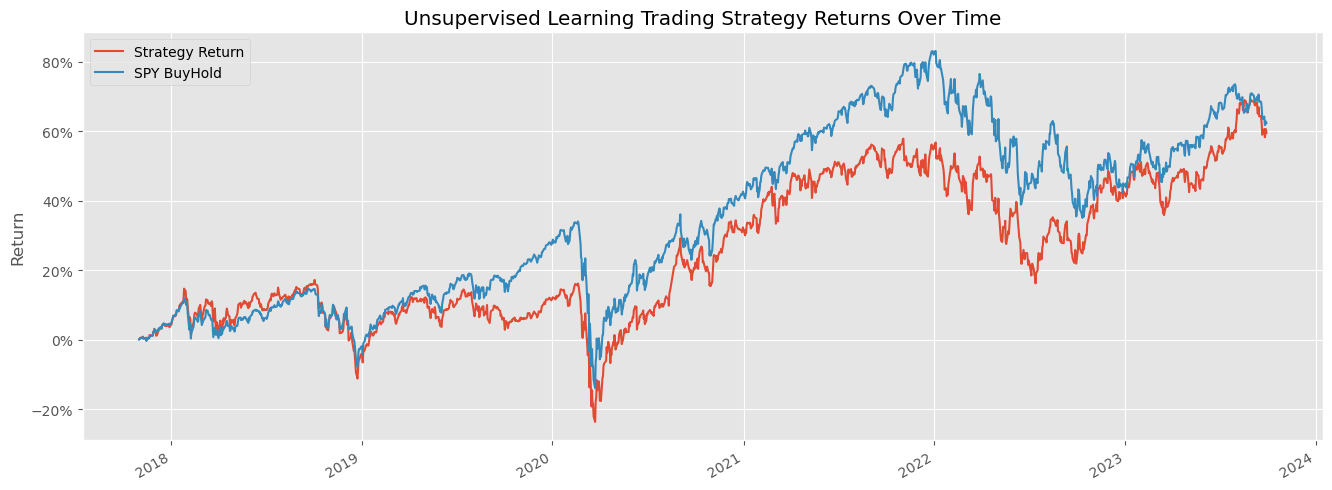

In [20]:
# 負けとるやん
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()